In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.experimental import enable_halving_search_cv
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

2024-04-01 08:38:06.095204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here we define any constants that will be resued throughout the notebook

**NOTE**: Change the variables ```FILEDIR``` and ```OUTDIR``` to appropiaste directories before running the notebook

In [2]:
####### CONSTANTS ########
# FILEDIR = "/home/s1835083/Desktop/numu_energy_studies.csv"
FILEDIR = "/home/giorgio/data/week_20/numu_energy_studies.csv"
OUTPUTDIR = "/home/giorgio/Desktop/model.h5"
FEATURES_HEADERS = ["total_hits2", "total_ring_PEs2", "recoDWallR2", "recoDWallZ2", "lambda_max_2",]
LABEL_HEADERS = ["trueKE",]
SEED = 42

# **Exercise 1**

## Loading any data

Here we will read in the csv file and perform some basic data manipulation.

First we drop any entries in the dataframe which contain NaNs. We later print a head of the dataframe to see what exactly is held in each column.

In [3]:
dataframe = pd.read_csv(FILEDIR, sep=",", header=0, index_col=0).set_index("i")

In [4]:
# Remove Nans
dataframe.dropna(inplace=True)

# Visualise the data
dataframe.head(10)

,neutrinoE,trueKE,recoE_lookup,total_PMTs_hits2,total_hits2,total_ring_PEs2,pot_length2,hits_pot_length2,recoDWallR2,recoDWallZ2,lambda_max_2,recoDWall_2,recoToWall_2,vtxTrackBias_2
i,,,,,,,,,,,,,,
0,664.541,236.327,22.35380,0.000000,0.023325,0.00000,0.662787,0.003754,0.003389,0.458415,0.650854,0.003389,0.220977,-0.011905
3,400.551,186.765,2.46971,0.000000,0.010075,0.00000,0.662787,0.001621,0.003389,0.458415,0.405903,0.003389,0.220977,-2.269040
4,633.353,448.481,409.95400,0.308444,0.080400,0.13070,0.531171,0.016146,0.035389,0.753969,0.537975,0.035389,0.494926,0.024453
7,845.921,586.647,37.83740,0.000000,0.011950,0.00000,0.918554,0.001388,0.042498,0.083664,0.830098,0.042498,0.805578,-0.007114
9,1323.140,963.822,1408.07000,0.111333,0.142300,0.26265,0.093641,0.162093,0.616305,0.164307,0.092105,0.358487,0.135845,-0.004307
10,602.977,435.152,908.66900,0.136222,0.071425,0.12375,0.009318,0.817594,-0.031748,0.808230,0.584673,-0.031748,0.474233,-0.009901
17,656.550,264.111,262.79900,0.099556,0.042525,0.05590,0.294422,0.015406,0.653350,0.118767,0.281821,0.259129,0.294422,0.011576
19,561.754,328.597,338.98900,0.077111,0.055850,0.08005,0.229034,0.026011,0.480335,0.235204,0.220081,0.480335,0.229034,0.011409
20,579.378,163.706,42.23790,0.000000,0.021075,0.00000,0.839011,0.002679,0.083842,0.166220,0.836803,0.083842,0.096443,0.012322


Now, we plot all the parameters which we plan to use to train the neural networks and the BRTs which will be created in this notebook 

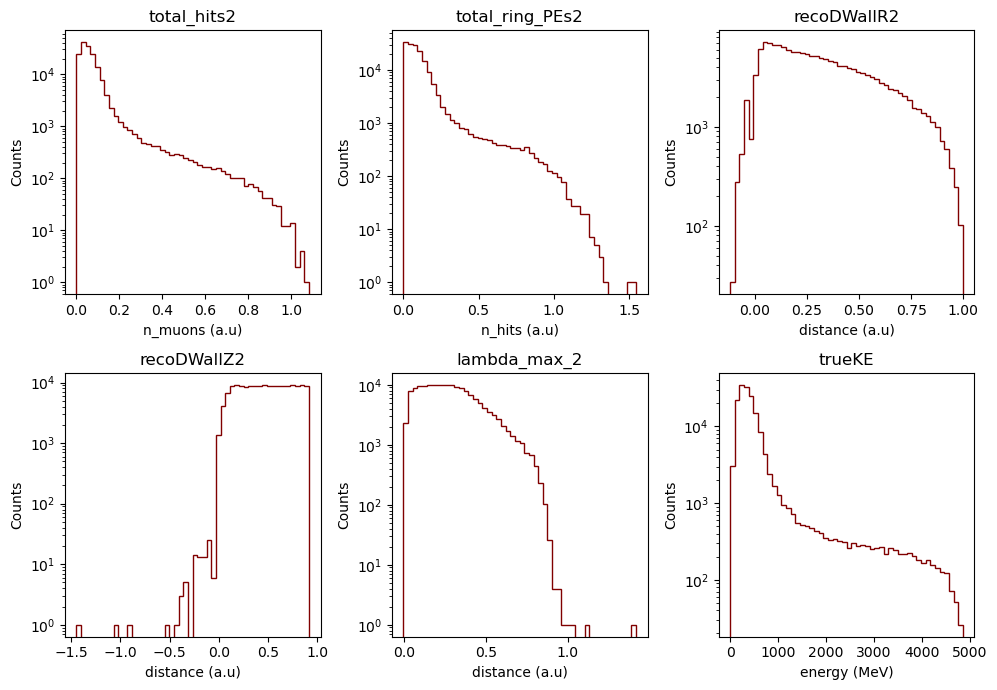

In [5]:
# Plot the distribution of variables which will be used

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
plot_headers = []
# Append all headers which will be plot
plot_headers.extend(FEATURES_HEADERS)
plot_headers.extend(LABEL_HEADERS)

# Define the c labels which will be plotted for each parameter
xlabels = ["n_muons (a.u)", "n_hits (a.u)", "distance (a.u)", "distance (a.u)", "distance (a.u)", "energy (MeV)"]

# Iterate over each axis in the plot
for header, axis, xlabel in zip(plot_headers, ax.flatten(), xlabels):
    # Plot the histogram
    axis.hist(dataframe[header], log=True, color="maroon", bins=50, histtype="step")
    axis.set(
        title=header,
        ylabel="Counts",
        xlabel=xlabel,
    )

plt.tight_layout()


In [6]:
# Define the dataset test/train split that will be uised to train the data
train_data, test_data, train_target, test_target = train_test_split (
    dataframe[FEATURES_HEADERS],
    dataframe[LABEL_HEADERS],
    test_size = 0.3,
    random_state = SEED, 
)

# Print size of datasets
print(f"Size of train features: {train_data.shape}")
print(f"Size of train labels:   {train_target.shape}")
print(f"Size of test features:  {test_data.shape}")
print(f"Size of test labels:    {test_target.shape}")

Size of train features: (114514, 5)
Size of train labels:   (114514, 1)
Size of test features:  (49078, 5)
Size of test labels:    (49078, 1)


# **Exercise 2**

## Building and testing a NN regressor

First we will define a function which will create a compiled NN which we can control the number of input and output features.

In [7]:
def build_regressor(input_features=5, output_features=1, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple wide layer wide dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, input_dim=input_features, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(16, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(8, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(4, kernel_initializer="normal"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network.compile(loss=loss, optimizer=optimizer)

    return network


Now we define the callbacks which will be called while training the neural network.

The callbacks which will be used is early stopping to finish training early if it has stagnated and checkpoint saving to save the best performing network

In [8]:
# Define our callbacks 
callbacks_ = [
    EarlyStopping(verbose=False, patience=10, monitor="loss"),
    ModelCheckpoint(OUTPUTDIR, monitor="loss", verbose=0, save_best_only=True , mode="max")
]

Now we will define our hyperparameters and build our NN regressor.

After building a pipeline object which contains our compiled regressor, we will perform 10 splits of a KFodl to find the cross validation r2 score to verify our network's performance

In [9]:
# Define Hyperparametrs
BATCH_SIZE = 64
EPOCHS = 40

# Make pseudorandom packages deterministic
np.random.seed(SEED)

# Define input pipeline with a compiled regressor
estimators = []
estimators.append (("mlp", KerasRegressor(build_fn=build_regressor, callbacks=callbacks_, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose =1)))
pipeline = Pipeline(estimators)

# Define the KFoold and perform a cross validation of different trained regressors to find an accurate r2 score for the model
kfold = KFold(n_splits =10, random_state=SEED, shuffle=True)
results = cross_val_score(pipeline , train_data , train_target , cv=kfold , scoring="r2")

# Print the results of the cross validation test
print("\nResult: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std ()))

Epoch 1/40


/tmp/ipykernel_45366/1558409741.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append (("mlp", KerasRegressor(build_fn=build_regressor, callbacks=callbacks_, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose =1)))
2024-04-01 08:38:08.537725: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1611/1611 [==============================] - 3s 1ms/step - loss: 259826.4219
Epoch 2/40
1611/1611 [==============================] - 2s 1ms/step - loss: 107615.0234
Epoch 3/40
1611/1611 [==============================] - 2s 1ms/step - loss: 106513.8359
Epoch 4/40
1611/1611 [==============================] - 2s 1ms/step - loss: 105747.2422
Epoch 5/40
1611/1611 [==============================] - 2s 1ms/step - loss: 105032.6406
Epoch 6/40
1611/1611 [==============================] - 2s 1ms/step - loss: 104431.4297
Epoch 7/40
1611/1611 [==============================] - 2s 980us/step - loss: 103745.7188
Epoch 8/40
1611/1611 [==============================] - 2s 1ms/step - loss: 103112.1250
Epoch 9/40
1611/1611 [==============================] - 2s 1ms/step - loss: 102428.8750
Epoch 10/40
1611/1611 [==============================] - 2s 1ms/step - loss: 101755.6953
Epoch 11/40
1611/1611 [==============================] - 2s 946us/step - loss: 101054.2188
Epoch 12/40
1611/1611 [==============

In [10]:
# Fit the network to the train dataset to obtain an object containing a trained regrerssor
network = build_regressor()
history = network.fit(train_data, train_target, validation_data=(test_data, test_target), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/40
1790/1790 [==============================] - 3s 1ms/step - loss: 236740.5625 - val_loss: 104689.7109
Epoch 2/40
1790/1790 [==============================] - 2s 1ms/step - loss: 107132.7578 - val_loss: 103251.5312
Epoch 3/40
1790/1790 [==============================] - 3s 2ms/step - loss: 106113.4453 - val_loss: 101942.1094
Epoch 4/40
1790/1790 [==============================] - 2s 1ms/step - loss: 105212.4531 - val_loss: 101429.9375
Epoch 5/40
1790/1790 [==============================] - 3s 2ms/step - loss: 104363.5391 - val_loss: 100249.8125
Epoch 6/40
1790/1790 [==============================] - 3s 1ms/step - loss: 103619.5469 - val_loss: 99344.3281
Epoch 7/40
1790/1790 [==============================] - 2s 1ms/step - loss: 102813.3828 - val_loss: 98568.7656
Epoch 8/40
1790/1790 [==============================] - 2s 1ms/step - loss: 101997.4453 - val_loss: 97596.4453
Epoch 9/40
1790/1790 [==============================] - 2s 1ms/step - loss: 101135.9922 - val_loss: 96708.8

Text(0.5, 1.0, 'Loss function (Training)')

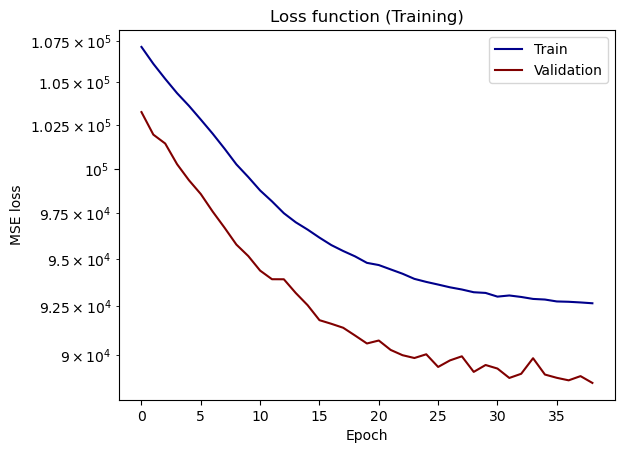

In [21]:
# Plot the loss function while training the regressor
plt.plot(history.history["loss"][1:], label="Train", color="darkblue")
plt.plot(history.history["val_loss"][1:], label="Validation", color="maroon")
plt.yscale("log")
plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.title("Loss function (Training)")

From the loss plot we see that the NN network has trained well due to the loss functon being well behaved troughout training. We see that after a while of training, the loss stagnates, indicating that the network has succesfully optimised the weights of the network. The only curiosity  is the fact that the validationloss is sysatematically smaller than the training los. This is not the tale tale indicaton of overtrainig (as the training loss would have to be smaller), therefore im not quitte sure whats going on there.

1534/1534 [==============================] - 1s 850us/step


Text(0.5, 1.0, 'RecoKE vs TruthKE')

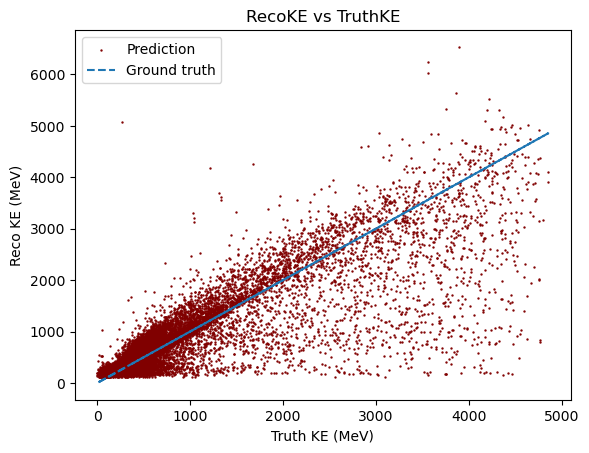

In [12]:
# Create a prediction using traind model
reco_KE_nn = network.predict(test_data)

# Create a plot of reco vs MC truth energy
plt.scatter(test_target, reco_KE_nn, s=0.5, c="maroon", label="Prediction")
plt.plot(test_target, test_target, ls="--", label="Ground truth")
plt.legend()
plt.xlabel("Truth KE (MeV)")
plt.ylabel("Reco KE (MeV)")
plt.title("RecoKE vs TruthKE")

From the plot, we see that a majority of the energies are well recosntricted, especially within the energy range between XX and XX MeV. At the energy range around XX MeV, we start totsee that the network underestimated the energy reconstructing an energy far smaller than the truch energy.

# **Exercise 3**

## GBRT Regressor

Now that we have trained a NN regressor, we will move on to training a gradient boosted regressiion tree. First we will define a GBRT using the default parameters and fit it to the training data 

In [13]:
# Make a dirty fit using basic params for regression tree
regressor_tree = GradientBoostingRegressor(n_estimators=100)
regressor_tree.fit(train_data , train_target.to_numpy().ravel())

GradientBoostingRegressor()

Now we print the r2 scores to see how the GBRT has perfromed. From what we can see, already using the default parameters, we have achieved an r2 score similar to that of the NN withoiut much hyperparameter tuning

In [14]:
# Get the r2 score of the trainied GBRT on both the train and validation datasets
train_r2 = regressor_tree.score(train_data, train_target.to_numpy())
test_r2 = regressor_tree.score(test_data, test_target.to_numpy())

# Print the r2 scores for the train data and test data
print(f"Train data r2: {train_r2:.4f}")
print(f"Validation data r2: {test_r2:.4f}")

Train data r2: 0.7831
Validation data r2: 0.7818


Now we define in a dictionary a range of hyprparameters which we want the gridsearch to sest to find optimal values

In [15]:
# Grid Search parameters
param_grid_ = {
    "n_estimators": [100],
    "learning_rate": np.linspace(1.5e-2, 2.5e-2, 20),
    "max_depth":    np.arange(10, 20),
    "min_samples_leaf": np.arange(10, 20,),
}
n_jobs_ = 10

Now we use HalvingGridSearchCV to iterate through different combinations of hyperparametes and retuen the optimal set of hyperparameters

In [16]:
# Define the seed for pseudo random generators
np.random.seed(SEED)

# Define the GBRT 
regressor = GradientBoostingRegressor ()
# Defin the grid search object and attempt to find the best set of hyperparams
classifier = HalvingGridSearchCV(estimator=regressor, cv=kfold , param_grid=param_grid_, n_jobs=n_jobs_, verbose =1)
classifier.fit(train_data, train_target.to_numpy().ravel())
# Print the best hyperparameters
print("Best estimator:")
print(classifier.best_estimator_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 157
max_resources_: 114514
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2000
n_resources: 157
Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
----------
iter: 1
n_candidates: 667
n_resources: 471
Fitting 10 folds for each of 667 candidates, totalling 6670 fits
----------
iter: 2
n_candidates: 223
n_resources: 1413
Fitting 10 folds for each of 223 candidates, totalling 2230 fits
----------
iter: 3
n_candidates: 75
n_resources: 4239
Fitting 10 folds for each of 75 candidates, totalling 750 fits
----------
iter: 4
n_candidates: 25
n_resources: 12717
Fitting 10 folds for each of 25 candidates, totalling 250 fits
----------
iter: 5
n_candidates: 9
n_resources: 38151
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 6
n_candidates: 3
n_resources: 114453
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best estimator:
Gradient

Now we use the best set of hyperparametes retuend by the grid search and include them in a pipeline to perform a cross validation test to find the r2 score of multiple GBRTs 

In [17]:
# Create a pipeline containing the best GBRT hyperparameters 
regressor_tree_estimators = []
regressor_tree_estimators.append (("mlp", classifier.best_estimator_))
pipeline = Pipeline(regressor_tree_estimators)
# Perform the cross validation test to find the overall r2 score of the best GBRT
results = cross_val_score(pipeline , train_data , train_target.to_numpy().ravel() , cv=kfold , scoring="r2")
# Print the result of the cross val test
print("Result: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std ()))

Result: 0.80 ± 0.01


Now we fit the best performing GBRT to the training data

Aftewr this, we use the trraind GBRT to find the predicted recostructed muon energy in the validation dataset

In [18]:
# Fit the best GBRT to the trainign dataset
classifier.best_estimator_.fit(train_data , train_target.to_numpy().ravel())
# Predct the muon energy in the validation dataset
reco_KE_gbrt = classifier.best_estimator_.predict(test_data)

Plot the reconstructed muon energy predicted by the GBRT against the MC truth values and plot side by side an identical plot with the predictions made by the NN regressor and compare the results

Text(0.5, 0.98, 'RecoKE vs TruthKE')

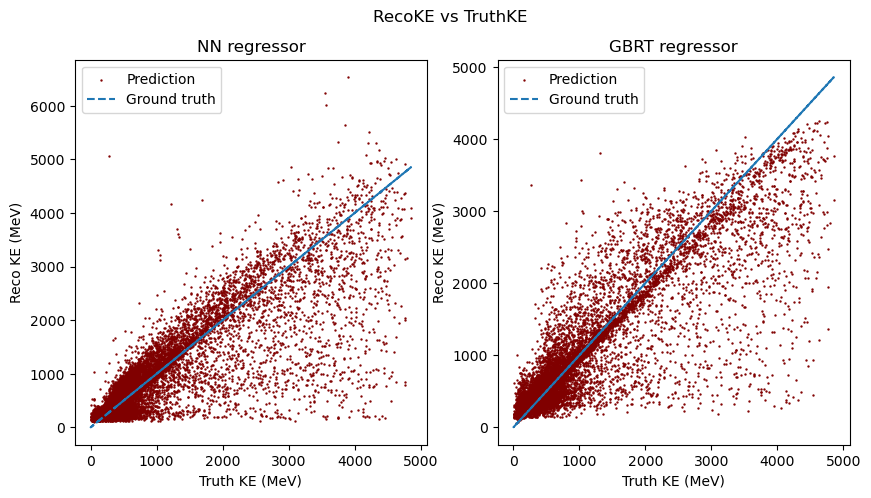

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a plot of reco vs MC truth energy for the NN regressor
ax1.scatter(test_target, reco_KE_nn, s=0.5, c="maroon", label="Prediction")
ax1.plot(test_target, test_target, ls="--", label="Ground truth")
ax1.legend()
ax1.set_xlabel("Truth KE (MeV)")
ax1.set_ylabel("Reco KE (MeV)")
ax1.set_title("NN regressor")

# Create a plot of reco vs MC truth energy for the GBRT regressor
ax2.scatter(test_target, reco_KE_gbrt, s=0.5, c="maroon", label="Prediction")
ax2.plot(test_target, test_target, ls="--", label="Ground truth")
ax2.legend()
ax2.set_xlabel("Truth KE (MeV)")
ax2.set_ylabel("Reco KE (MeV)")
ax2.set_title("GBRT regressor")


fig.suptitle("RecoKE vs TruthKE")

From the r2 scores obtained from the cross validation score, we know that the GBRT performs better from the NN regressor, but not by much. As is expected, both regressorsd do a good job at recosntructing the low energy muon energies. At the higher muon energies, wee see that the GBRT does a slightly better job at correctly reconstructing the energy. This is tyhe likely causefor the increased r2 score in the cross validation test of the GBRT

Now we will look at the importance of each parameter provided to the GBRT to see which one is most improtant for the reconstruction of muon energy

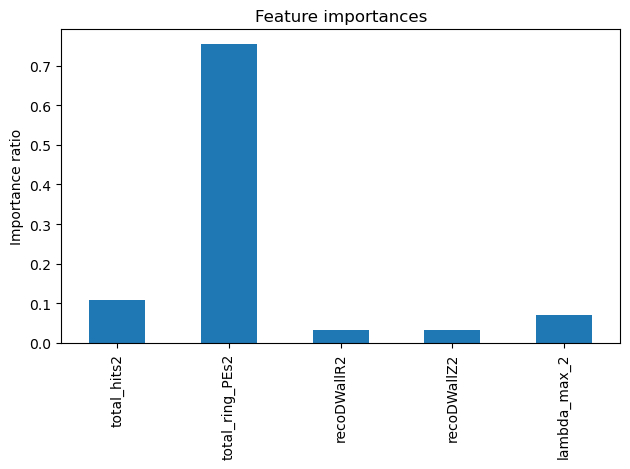

In [20]:
# Get importance of each feature provided to the GBRT
importances = classifier.best_estimator_.feature_importances_

# Prooduce a pandas series witht the 
forest_importances = pd.Series(importances, index=FEATURES_HEADERS)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Importance ratio")
fig.tight_layout()

From the feature importance plot, we imediatly identify that the main feature which is used by the GBRT to reconstruct the muon energy is the number of PMTs hits assigned to a cherenkov ring.